In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# ensure directories exist
IMAGES_DIR = Path('Images/Deliverable-1')
IMAGES_DIR.mkdir(parents=True, exist_ok=True)
RESULTS_DIR = Path('Result_CSVs/Deliverable-1')
RESULTS_DIR.mkdir(parents=True, exist_ok=True)

# display options & style for visualisation
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

In [2]:
# Load all datasets
flight_df = pd.read_csv('Dataset/Flight_Level_Data.csv')
pnr_flight_df = pd.read_csv('Dataset/PNR_Flight_Level_Data.csv')
pnr_remarks_df = pd.read_csv('Dataset/PNR_Remark_Level_Data.csv')
airports_df = pd.read_csv('Dataset/Airports_Data.csv')
bag_df = pd.read_csv('Dataset/Bag_Level_Data.csv')

print("Data loaded")
print(f"\nFlight data shape: {flight_df.shape}")
print(f"PNR Flight data shape: {pnr_flight_df.shape}")
print(f"PNR Remarks data shape: {pnr_remarks_df.shape}")
print(f"Airports data shape: {airports_df.shape}")
print(f"Bag data shape: {bag_df.shape}")

Data loaded

Flight data shape: (8099, 15)
PNR Flight data shape: (687878, 12)
PNR Remarks data shape: (51698, 4)
Airports data shape: (5612, 2)
Bag data shape: (687245, 8)


In [3]:
# datetime format
datetime_cols_flight = ['scheduled_departure_datetime_local', 
                        'scheduled_arrival_datetime_local',
                        'actual_departure_datetime_local', 
                        'actual_arrival_datetime_local']

for col in datetime_cols_flight:
    if col in flight_df.columns:
        flight_df[col] = pd.to_datetime(flight_df[col])

flight_df['scheduled_departure_date_local'] = pd.to_datetime(flight_df['scheduled_departure_date_local'])
pnr_flight_df['scheduled_departure_date_local'] = pd.to_datetime(pnr_flight_df['scheduled_departure_date_local'])
bag_df['scheduled_departure_date_local'] = pd.to_datetime(bag_df['scheduled_departure_date_local'])

print("Datetime conversion")
print("\n Given Dataset:")
print(flight_df.info())
print(bag_df.info())
print(pnr_flight_df.info())
print(pnr_remarks_df.info())
print(airports_df.info())

Datetime conversion

 Given Dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8099 entries, 0 to 8098
Data columns (total 15 columns):
 #   Column                              Non-Null Count  Dtype              
---  ------                              --------------  -----              
 0   company_id                          8099 non-null   object             
 1   flight_number                       8099 non-null   int64              
 2   scheduled_departure_date_local      8099 non-null   datetime64[ns]     
 3   scheduled_departure_station_code    8099 non-null   object             
 4   scheduled_arrival_station_code      8099 non-null   object             
 5   scheduled_departure_datetime_local  8099 non-null   datetime64[ns, UTC]
 6   scheduled_arrival_datetime_local    8099 non-null   datetime64[ns, UTC]
 7   actual_departure_datetime_local     8099 non-null   datetime64[ns, UTC]
 8   actual_arrival_datetime_local       8099 non-null   datetime64[ns, UTC]
 9   tota

In [4]:
# departure delay (min)
flight_df['departure_delay_minutes'] = (
    flight_df['actual_departure_datetime_local'] - 
    flight_df['scheduled_departure_datetime_local']
).dt.total_seconds() / 60

# remove null vals
valid_delays = flight_df['departure_delay_minutes'].dropna()

# average delay
average_delay = valid_delays.mean()

# percentage of late departures (delay > 15 minutes - industry standard)
late_departures = (valid_delays > 15).sum()
total_flights = len(valid_delays)
pct_late_departures = (late_departures / total_flights) * 100

print("="*60)
print("TASK 1: DELAY ANALYSIS")
print("="*60)
print(f"\nAverage Departure Delay: {average_delay:.2f} minutes")
print(f"Total Flights Analyzed: {total_flights:,}")
print(f"Late Departures (delay > 15 min): {late_departures:,}")
print(f"Percentage of Late Departures: {pct_late_departures:.2f}%")
print(f"\nDelay Statistics:")
print(f"  Median Delay: {valid_delays.median():.2f} minutes")
print(f"  Std Dev: {valid_delays.std():.2f} minutes")
print(f"  Min Delay: {valid_delays.min():.2f} minutes")
print(f"  Max Delay: {valid_delays.max():.2f} minutes")

TASK 1: DELAY ANALYSIS

Average Departure Delay: 21.18 minutes
Total Flights Analyzed: 8,099
Late Departures (delay > 15 min): 2,163
Percentage of Late Departures: 26.71%

Delay Statistics:
  Median Delay: 0.00 minutes
  Std Dev: 62.17 minutes
  Min Delay: -17.00 minutes
  Max Delay: 1017.00 minutes


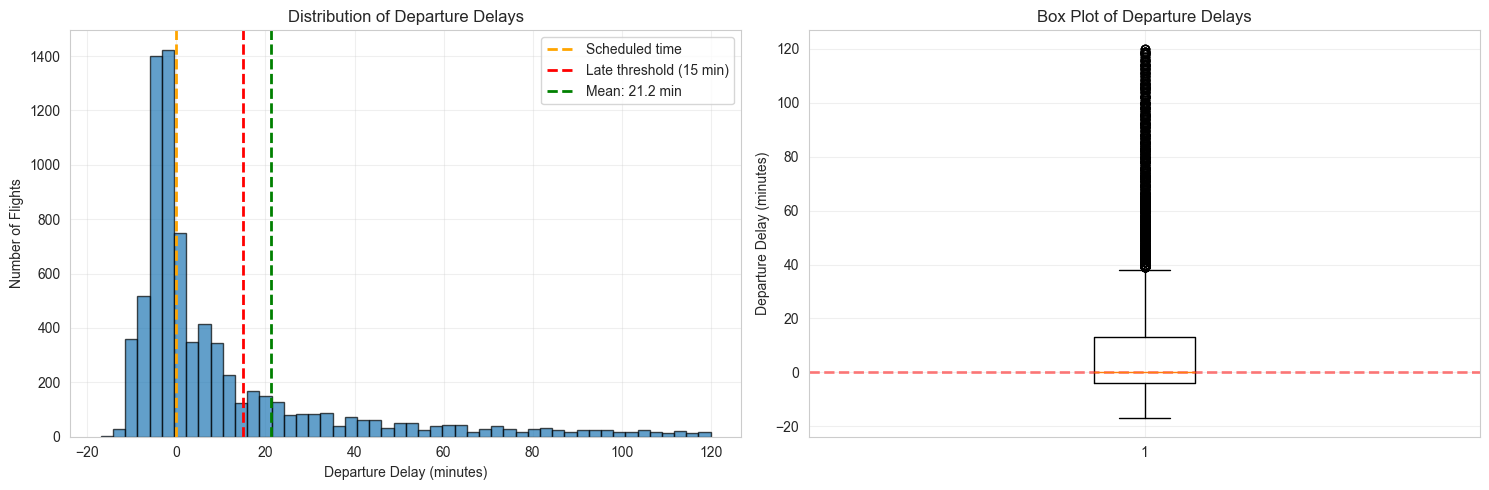

In [5]:
# delay distribution
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# histogram of delays
axes[0].hist(valid_delays[valid_delays.between(-30, 120)], bins=50, edgecolor='black', alpha=0.7)
axes[0].axvline(0, color='orange', linestyle='--', linewidth=2, label='Scheduled time')
axes[0].axvline(15, color='red', linestyle='--', linewidth=2, label='Late threshold (15 min)')
axes[0].axvline(average_delay, color='green', linestyle='--', linewidth=2, label=f'Mean: {average_delay:.1f} min')
axes[0].set_xlabel('Departure Delay (minutes)')
axes[0].set_ylabel('Number of Flights')
axes[0].set_title('Distribution of Departure Delays')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# box plot
axes[1].boxplot(valid_delays[valid_delays.between(-30, 120)], vert=True)
axes[1].set_ylabel('Departure Delay (minutes)')
axes[1].set_title('Box Plot of Departure Delays')
axes[1].axhline(0, color='red', linestyle='--', linewidth=2, alpha=0.5)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
fig.savefig(IMAGES_DIR / 'eda_delays.png', dpi=200, bbox_inches='tight')
plt.show()

In [6]:
# flights with scheduled ground time at or below minimum turn time
flight_df['ground_time_risk'] = flight_df['scheduled_ground_time_minutes'] <= flight_df['minimum_turn_minutes']

# no. of risky flights
risky_flights = flight_df['ground_time_risk'].sum()
total_flights_with_ground_time = flight_df['ground_time_risk'].notna().sum()
pct_risky = (risky_flights / total_flights_with_ground_time) * 100

# ground time buffer
flight_df['ground_time_buffer'] = flight_df['scheduled_ground_time_minutes'] - flight_df['minimum_turn_minutes']

print("="*60)
print("TASK 2: GROUND TIME RISK ANALYSIS")
print("="*60)
print(f"\nFlights with Ground Time <= Minimum Turn Time: {risky_flights:,}")
print(f"Total Flights Analyzed: {total_flights_with_ground_time:,}")
print(f"Percentage at Risk: {pct_risky:.2f}%")
print(f"\nGround Time Buffer Statistics:")
print(f"  Average Buffer: {flight_df['ground_time_buffer'].mean():.2f} minutes")
print(f"  Median Buffer: {flight_df['ground_time_buffer'].median():.2f} minutes")
print(f"  Min Buffer: {flight_df['ground_time_buffer'].min():.2f} minutes")
print(f"  Max Buffer: {flight_df['ground_time_buffer'].max():.2f} minutes")

# distribution by fleet type
print("\n" + "="*60)
print("Ground Time Risk by Fleet Type:")
print("="*60)
risk_by_fleet = flight_df.groupby('fleet_type').agg({
    'ground_time_risk': ['sum', 'count'],
    'ground_time_buffer': 'mean'
}).round(2)
risk_by_fleet.columns = ['Risky_Flights', 'Total_Flights', 'Avg_Buffer_Minutes']
risk_by_fleet['Risk_Percentage'] = (risk_by_fleet['Risky_Flights'] / risk_by_fleet['Total_Flights'] * 100).round(2)
print(risk_by_fleet.sort_values('Risk_Percentage', ascending=False))

TASK 2: GROUND TIME RISK ANALYSIS

Flights with Ground Time <= Minimum Turn Time: 652
Total Flights Analyzed: 8,099
Percentage at Risk: 8.05%

Ground Time Buffer Statistics:
  Average Buffer: 135.75 minutes
  Median Buffer: 29.00 minutes
  Min Buffer: -1009.00 minutes
  Max Buffer: 33281.00 minutes

Ground Time Risk by Fleet Type:
            Risky_Flights  Total_Flights  Avg_Buffer_Minutes  Risk_Percentage
fleet_type                                                                   
B767-400                2              2               -7.00           100.00
B737-800              121            674               92.10            17.95
B737-900               94            809              116.05            11.62
B737-700               41            395              108.83            10.38
B757-200               10            105              202.25             9.52
B767-300                5             60              455.75             8.33
B787-10                11            141   

In [7]:
# aggregate bags by flight
bag_summary = bag_df.groupby([
    'company_id', 
    'flight_number', 
    'scheduled_departure_date_local',
    'scheduled_departure_station_code',
    'scheduled_arrival_station_code',
    'bag_type'
]).size().reset_index(name='bag_count')

# pivot to get different bag types
bag_pivot = bag_summary.pivot_table(
    index=['company_id', 'flight_number', 'scheduled_departure_date_local',
           'scheduled_departure_station_code', 'scheduled_arrival_station_code'],
    columns='bag_type',
    values='bag_count',
    fill_value=0
).reset_index()

print("Available bag types:", bag_pivot.columns.tolist())

# Origin bags are essentially "checked" bags originating from this station
# Transfer bags are connecting from another flight
# Hot Transfer bags are transfers with <30 min connection time

# rename for clarity
if 'Origin' in bag_pivot.columns:
    bag_pivot['Checked'] = bag_pivot['Origin']

# handle all transfer types
if 'Transfer' in bag_pivot.columns and 'Hot Transfer' in bag_pivot.columns:
    bag_pivot['All_Transfers'] = bag_pivot['Transfer'] + bag_pivot['Hot Transfer']
elif 'Transfer' in bag_pivot.columns:
    bag_pivot['All_Transfers'] = bag_pivot['Transfer']
elif 'Hot Transfer' in bag_pivot.columns:
    bag_pivot['All_Transfers'] = bag_pivot['Hot Transfer']

# total bags and ratios
bag_pivot['total_bags'] = bag_pivot[[col for col in ['Origin', 'Transfer', 'Hot Transfer'] 
                                      if col in bag_pivot.columns]].sum(axis=1)

# transfer to checked ratio
bag_pivot['transfer_to_checked_ratio'] = np.where(
    bag_pivot['Checked'] > 0,
    bag_pivot['All_Transfers'] / bag_pivot['Checked'],
    np.nan
)

# hot transfer percentage (imp operational metric)
if 'Hot Transfer' in bag_pivot.columns:
    bag_pivot['hot_transfer_pct'] = np.where(
        bag_pivot['All_Transfers'] > 0,
        (bag_pivot['Hot Transfer'] / bag_pivot['All_Transfers'] * 100),
        0
    )

avg_ratio = bag_pivot['transfer_to_checked_ratio'].mean()
median_ratio = bag_pivot['transfer_to_checked_ratio'].median()

print("="*60)
print("TASK 3: BAG RATIO ANALYSIS")
print("="*60)
print(f"\nAverage Transfer to Checked Bag Ratio: {avg_ratio:.4f}")
print(f"Median Transfer to Checked Bag Ratio: {median_ratio:.4f}")
print(f"\nTotal Flights with Bag Data: {len(bag_pivot):,}")

print(f"\nBag Type Summary:")
if 'Origin' in bag_pivot.columns:
    print(f"  Total Origin (Checked) Bags: {bag_pivot['Origin'].sum():,}")
if 'Transfer' in bag_pivot.columns:
    print(f"  Total Regular Transfer Bags: {bag_pivot['Transfer'].sum():,}")
if 'Hot Transfer' in bag_pivot.columns:
    print(f"  Total Hot Transfer Bags: {bag_pivot['Hot Transfer'].sum():,}")
print(f"  Total All Transfer Bags: {bag_pivot['All_Transfers'].sum():,}")
print(f"  Total All Bags: {bag_pivot['total_bags'].sum():,}")

print(f"\nAverage Bags per Flight:")
if 'Origin' in bag_pivot.columns:
    print(f"  Origin (Checked): {bag_pivot['Origin'].mean():.2f}")
if 'Transfer' in bag_pivot.columns:
    print(f"  Regular Transfer: {bag_pivot['Transfer'].mean():.2f}")
if 'Hot Transfer' in bag_pivot.columns:
    print(f"  Hot Transfer: {bag_pivot['Hot Transfer'].mean():.2f}")
print(f"  All Transfers: {bag_pivot['All_Transfers'].mean():.2f}")
print(f"  Total: {bag_pivot['total_bags'].mean():.2f}")

if 'Hot Transfer' in bag_pivot.columns:
    print(f"\nHot Transfer Statistics (Critical <30 min connections):")
    print(f"  Average Hot Transfers per Flight: {bag_pivot['Hot Transfer'].mean():.2f}")
    print(f"  Flights with Hot Transfers: {(bag_pivot['Hot Transfer'] > 0).sum():,}")
    print(f"  Average Hot Transfer % of All Transfers: {bag_pivot['hot_transfer_pct'].mean():.2f}%")

Available bag types: ['company_id', 'flight_number', 'scheduled_departure_date_local', 'scheduled_departure_station_code', 'scheduled_arrival_station_code', 'Hot Transfer', 'Origin', 'Transfer']
TASK 3: BAG RATIO ANALYSIS

Average Transfer to Checked Bag Ratio: 3.7179
Median Transfer to Checked Bag Ratio: 1.6000

Total Flights with Bag Data: 10,863

Bag Type Summary:
  Total Origin (Checked) Bags: 290,121.0
  Total Regular Transfer Bags: 347,546.0
  Total Hot Transfer Bags: 49,578.0
  Total All Transfer Bags: 397,124.0
  Total All Bags: 687,245.0

Average Bags per Flight:
  Origin (Checked): 26.71
  Regular Transfer: 31.99
  Hot Transfer: 4.56
  All Transfers: 36.56
  Total: 63.26

Hot Transfer Statistics (Critical <30 min connections):
  Average Hot Transfers per Flight: 4.56
  Flights with Hot Transfers: 5,936
  Average Hot Transfer % of All Transfers: 11.95%


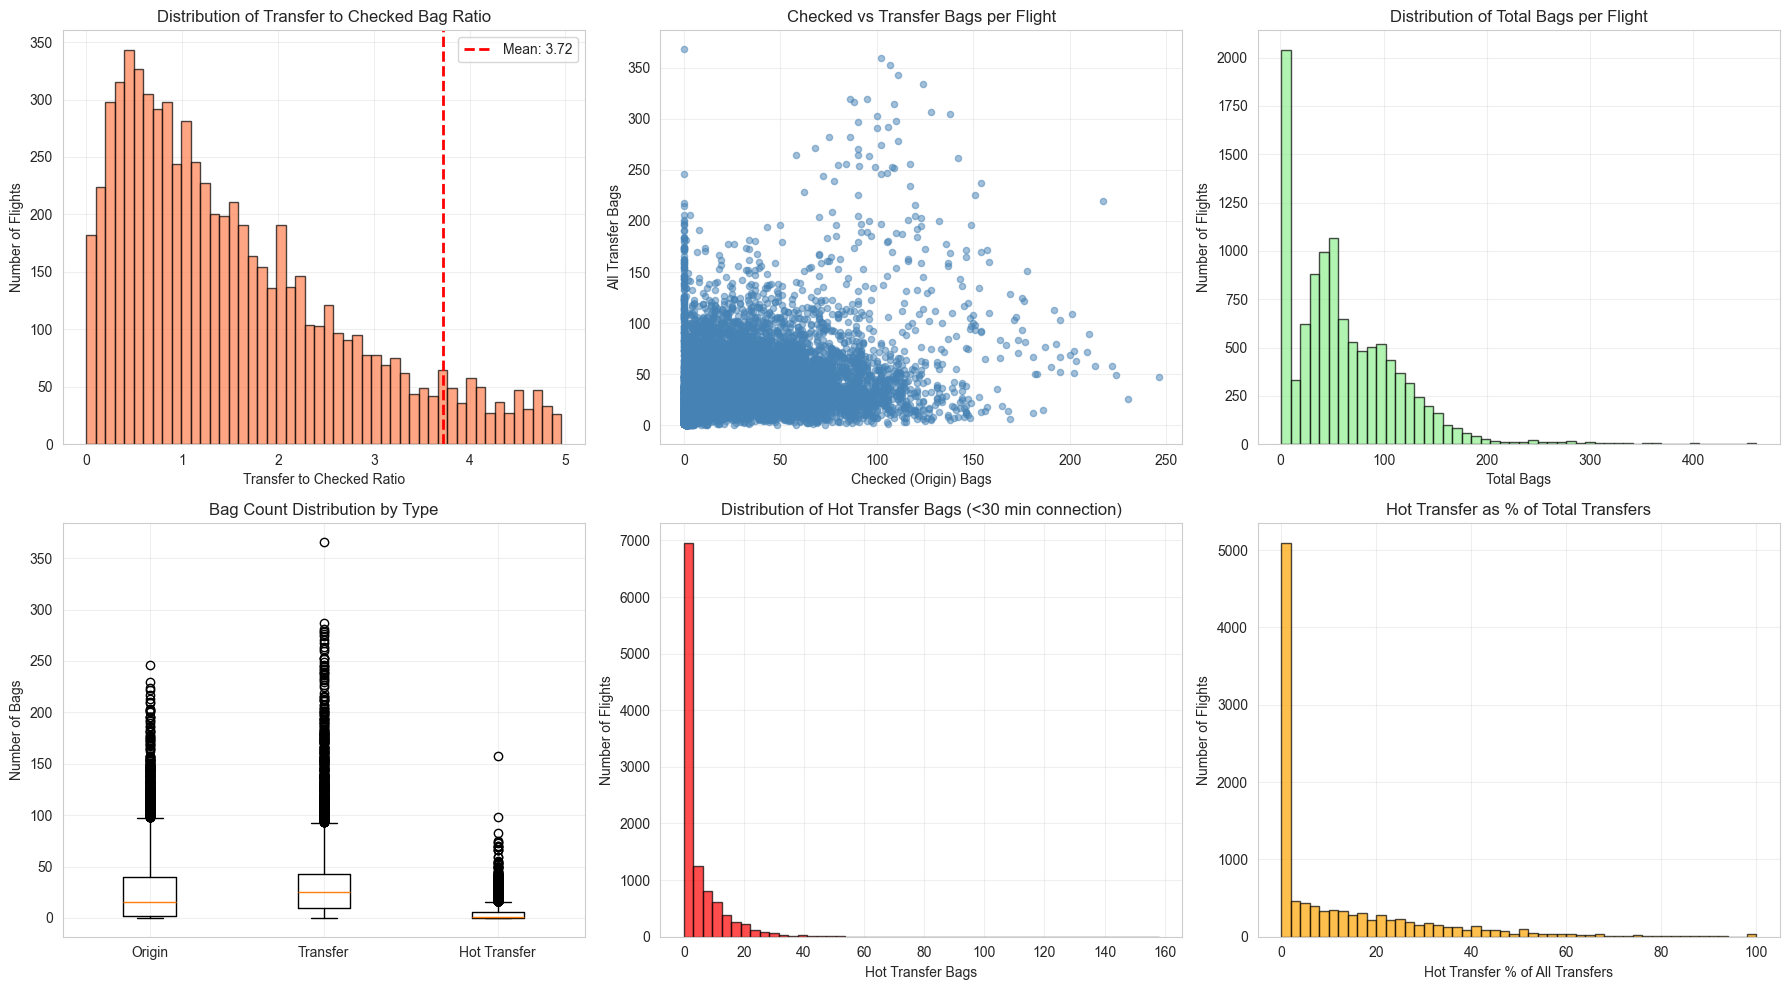


HIGH-RISK BAG SITUATIONS

Flights with Transfer:Checked ratio > 2: 3,491
  Average total bags: 66.34

Flights with >10 Hot Transfers: 1,631
  Average hot transfers: 19.01
  Average total bags: 103.48


In [8]:
# visualizations for bag analysis
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# ratio distribution
ratio_data = bag_pivot['transfer_to_checked_ratio'].dropna()
axes[0, 0].hist(ratio_data[ratio_data < 5], bins=50, edgecolor='black', alpha=0.7, color='coral')
axes[0, 0].axvline(avg_ratio, color='red', linestyle='--', linewidth=2, label=f'Mean: {avg_ratio:.2f}')
axes[0, 0].set_xlabel('Transfer to Checked Ratio')
axes[0, 0].set_ylabel('Number of Flights')
axes[0, 0].set_title('Distribution of Transfer to Checked Bag Ratio')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# scatter: Checked vs All Transfer bags
axes[0, 1].scatter(bag_pivot['Checked'], bag_pivot['All_Transfers'], alpha=0.5, s=20, c='steelblue')
axes[0, 1].set_xlabel('Checked (Origin) Bags')
axes[0, 1].set_ylabel('All Transfer Bags')
axes[0, 1].set_title('Checked vs Transfer Bags per Flight')
axes[0, 1].grid(True, alpha=0.3)

# total bags distribution
axes[0, 2].hist(bag_pivot['total_bags'], bins=50, edgecolor='black', alpha=0.7, color='lightgreen')
axes[0, 2].set_xlabel('Total Bags')
axes[0, 2].set_ylabel('Number of Flights')
axes[0, 2].set_title('Distribution of Total Bags per Flight')
axes[0, 2].grid(True, alpha=0.3)

# box plots for bag types
if 'Hot Transfer' in bag_pivot.columns:
    bag_types_data = [
        bag_pivot['Origin'].values, 
        bag_pivot['Transfer'].values,
        bag_pivot['Hot Transfer'].values
    ]
    labels = ['Origin', 'Transfer', 'Hot Transfer']
else:
    bag_types_data = [
        bag_pivot['Origin'].values, 
        bag_pivot['Transfer'].values
    ]
    labels = ['Origin', 'Transfer']

axes[1, 0].boxplot(bag_types_data, labels=labels)
axes[1, 0].set_ylabel('Number of Bags')
axes[1, 0].set_title('Bag Count Distribution by Type')
axes[1, 0].grid(True, alpha=0.3)

# hot Transfer analysis
if 'Hot Transfer' in bag_pivot.columns:
    # Distribution of hot transfers
    axes[1, 1].hist(bag_pivot['Hot Transfer'], bins=50, edgecolor='black', alpha=0.7, color='red')
    axes[1, 1].set_xlabel('Hot Transfer Bags')
    axes[1, 1].set_ylabel('Number of Flights')
    axes[1, 1].set_title('Distribution of Hot Transfer Bags (<30 min connection)')
    axes[1, 1].grid(True, alpha=0.3)
    
    # hot transfer percentage
    axes[1, 2].hist(bag_pivot['hot_transfer_pct'], bins=50, edgecolor='black', alpha=0.7, color='orange')
    axes[1, 2].set_xlabel('Hot Transfer % of All Transfers')
    axes[1, 2].set_ylabel('Number of Flights')
    axes[1, 2].set_title('Hot Transfer as % of Total Transfers')
    axes[1, 2].grid(True, alpha=0.3)
else:
    axes[1, 1].axis('off')
    axes[1, 2].axis('off')

plt.tight_layout()
fig.savefig(IMAGES_DIR / 'eda_bags.png', dpi=200, bbox_inches='tight')
plt.show()

# summary statistics about high-risk bag situations
print("\n" + "="*60)
print("HIGH-RISK BAG SITUATIONS")
print("="*60)

# flights with very high transfer ratios
high_transfer_ratio = bag_pivot[bag_pivot['transfer_to_checked_ratio'] > 2]
print(f"\nFlights with Transfer:Checked ratio > 2: {len(high_transfer_ratio):,}")
if len(high_transfer_ratio) > 0:
    print(f"  Average total bags: {high_transfer_ratio['total_bags'].mean():.2f}")

# flights with many hot transfers
if 'Hot Transfer' in bag_pivot.columns:
    high_hot_transfer = bag_pivot[bag_pivot['Hot Transfer'] > 10]
    print(f"\nFlights with >10 Hot Transfers: {len(high_hot_transfer):,}")
    if len(high_hot_transfer) > 0:
        print(f"  Average hot transfers: {high_hot_transfer['Hot Transfer'].mean():.2f}")
        print(f"  Average total bags: {high_hot_transfer['total_bags'].mean():.2f}")

In [9]:
# aggr. PNR data to get passenger counts per flight
pnr_agg = pnr_flight_df.groupby([
    'company_id', 
    'flight_number', 
    'scheduled_departure_date_local',
    'scheduled_departure_station_code',
    'scheduled_arrival_station_code'
]).agg({
    'total_pax': 'sum',
    'lap_child_count': 'sum',
    'is_child': lambda x: (x == 'Y').sum(),  # Count 'Y' values
    'basic_economy_ind': 'sum',  # Changed from basic_economy_pax
    'is_stroller_user': lambda x: (x == 'Y').sum()  # Count 'Y' values
}).reset_index()

# rename columns for readabilitty
pnr_agg.columns = ['company_id', 'flight_number', 'scheduled_departure_date_local',
                    'scheduled_departure_station_code', 'scheduled_arrival_station_code',
                    'total_pax', 'lap_child_count', 'child_count', 'basic_economy_pax', 'stroller_count']

# merge with flight data
flight_with_pax = flight_df.merge(
    pnr_agg,
    on=['company_id', 'flight_number', 'scheduled_departure_date_local',
        'scheduled_departure_station_code', 'scheduled_arrival_station_code'],
    how='left'
)

# load factor
flight_with_pax['load_factor'] = (flight_with_pax['total_pax'] / flight_with_pax['total_seats'] * 100)

print("="*60)
print("TASK 4: PASSENGER LOAD ANALYSIS")
print("="*60)
print(f"\nPassenger Load Statistics:")
print(f"  Average Passengers per Flight: {flight_with_pax['total_pax'].mean():.2f}")
print(f"  Average Load Factor: {flight_with_pax['load_factor'].mean():.2f}%")
print(f"  Median Load Factor: {flight_with_pax['load_factor'].median():.2f}%")
print(f"\nLoad Factor Distribution:")
print(f"  < 50%: {(flight_with_pax['load_factor'] < 50).sum():,} flights")
print(f"  50-75%: {flight_with_pax['load_factor'].between(50, 75).sum():,} flights")
print(f"  75-90%: {flight_with_pax['load_factor'].between(75, 90).sum():,} flights")
print(f"  > 90%: {(flight_with_pax['load_factor'] > 90).sum():,} flights")

print(f"\nPassenger Composition:")
print(f"  Average Children per Flight: {flight_with_pax['child_count'].mean():.2f}")
print(f"  Average Lap Children per Flight: {flight_with_pax['lap_child_count'].mean():.2f}")
print(f"  Average Basic Economy Passengers: {flight_with_pax['basic_economy_pax'].mean():.2f}")
print(f"  Average Stroller Users: {flight_with_pax['stroller_count'].mean():.2f}")

# load factor and delay co-relation
valid_data = flight_with_pax[['load_factor', 'departure_delay_minutes']].dropna()
correlation = valid_data.corr().iloc[0, 1]

print(f"\n" + "="*60)
print(f"Correlation between Load Factor and Departure Delay: {correlation:.4f}")
print("="*60)

# compare delays by load category
flight_with_pax['load_category'] = pd.cut(
    flight_with_pax['load_factor'],
    bins=[0, 50, 75, 90, 100],
    labels=['Low (<50%)', 'Medium (50-75%)', 'High (75-90%)', 'Very High (>90%)']
)

delay_by_load = flight_with_pax.groupby('load_category')['departure_delay_minutes'].agg([
    'count', 'mean', 'median', 'std'
]).round(2)
print(f"\nDelay Statistics by Load Category:")
print(delay_by_load)

print(f"\n" + "="*60)
print("PASSENGER COMPLEXITY INDICATORS:")
print("="*60)
flight_with_pax['child_ratio'] = flight_with_pax['child_count'] / flight_with_pax['total_pax']
flight_with_pax['basic_econ_ratio'] = flight_with_pax['basic_economy_pax'] / flight_with_pax['total_pax']

print(f"Average Child Ratio: {flight_with_pax['child_ratio'].mean():.4f}")
print(f"Average Basic Economy Ratio: {flight_with_pax['basic_econ_ratio'].mean():.4f}")

TASK 4: PASSENGER LOAD ANALYSIS

Passenger Load Statistics:
  Average Passengers per Flight: 128.48
  Average Load Factor: 102.42%
  Median Load Factor: 104.76%

Load Factor Distribution:
  < 50%: 207 flights
  50-75%: 533 flights
  75-90%: 924 flights
  > 90%: 6,437 flights

Passenger Composition:
  Average Children per Flight: 5.18
  Average Lap Children per Flight: 0.69
  Average Basic Economy Passengers: 10.18
  Average Stroller Users: 1.09

Correlation between Load Factor and Departure Delay: -0.1502

Delay Statistics by Load Category:
                  count   mean  median     std
load_category                                 
Low (<50%)          218  59.59     1.0  144.32
Medium (50-75%)     522  45.78     2.0  116.88
High (75-90%)       922  29.88     0.0   82.62
Very High (>90%)   1572  17.01     0.0   45.87

PASSENGER COMPLEXITY INDICATORS:
Average Child Ratio: 0.0350
Average Basic Economy Ratio: 0.0804


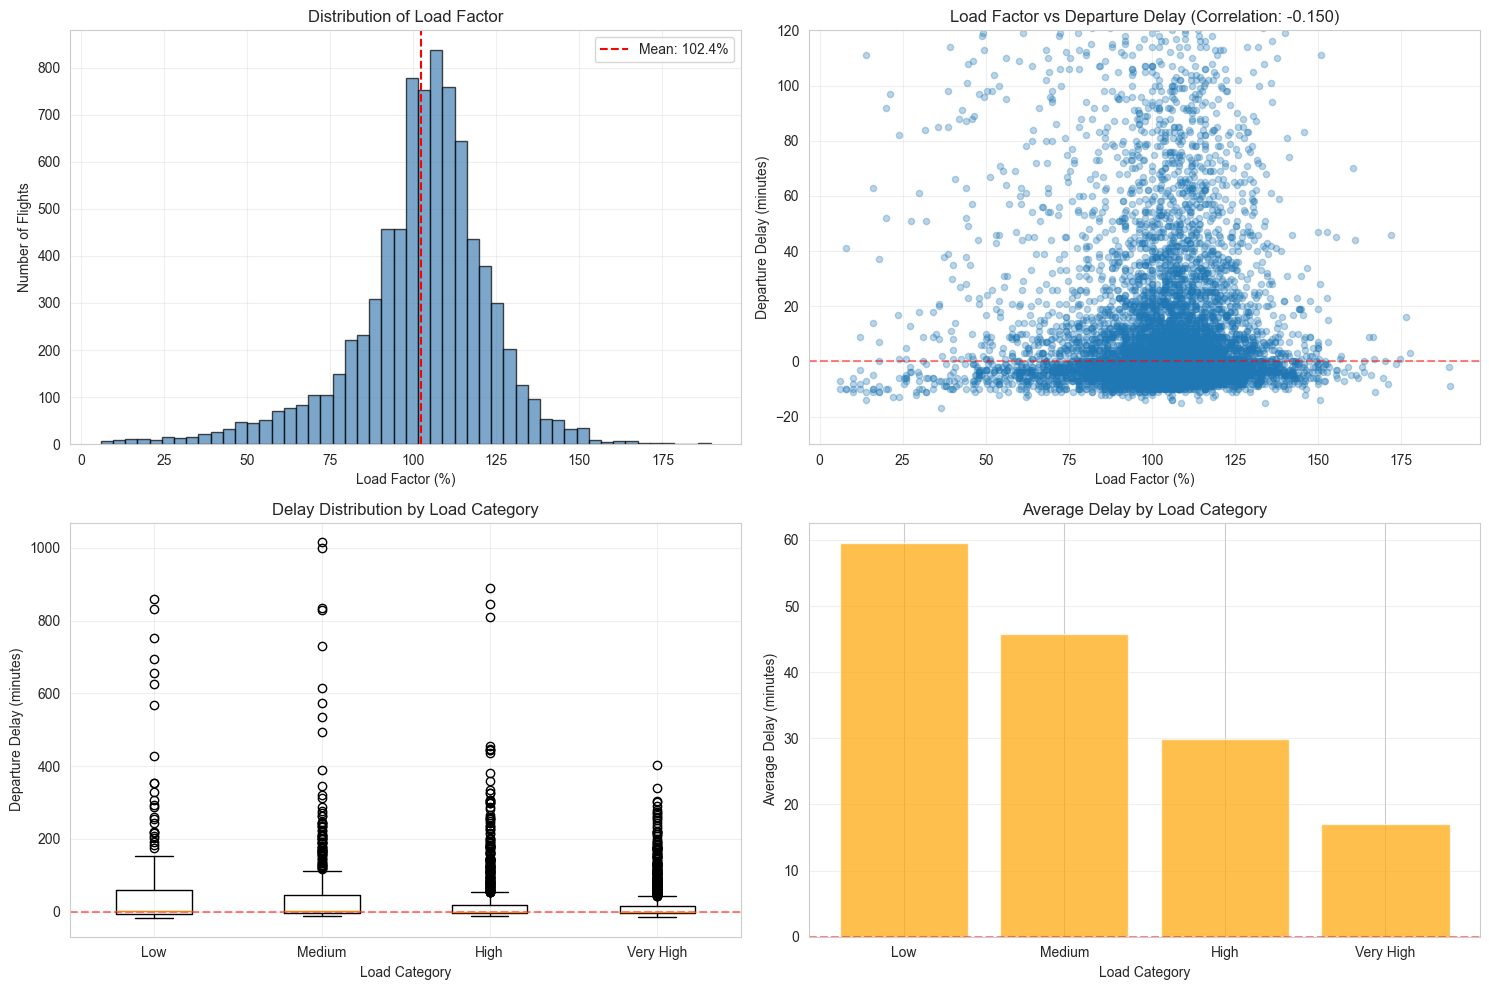

In [10]:
# visualizations for passenger load
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# load factor distribution
axes[0, 0].hist(flight_with_pax['load_factor'].dropna(), bins=50, edgecolor='black', alpha=0.7, color='steelblue')
axes[0, 0].set_xlabel('Load Factor (%)')
axes[0, 0].set_ylabel('Number of Flights')
axes[0, 0].set_title('Distribution of Load Factor')
axes[0, 0].axvline(flight_with_pax['load_factor'].mean(), color='red', linestyle='--', 
                   label=f'Mean: {flight_with_pax["load_factor"].mean():.1f}%')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# scatter: Load Factor vs Delay
valid_scatter = flight_with_pax[['load_factor', 'departure_delay_minutes']].dropna()
axes[0, 1].scatter(valid_scatter['load_factor'], valid_scatter['departure_delay_minutes'], alpha=0.3, s=20)
axes[0, 1].set_xlabel('Load Factor (%)')
axes[0, 1].set_ylabel('Departure Delay (minutes)')
axes[0, 1].set_title(f'Load Factor vs Departure Delay (Correlation: {correlation:.3f})')
axes[0, 1].axhline(0, color='red', linestyle='--', alpha=0.5)
axes[0, 1].grid(True, alpha=0.3)
axes[0, 1].set_ylim(-30, 120)

# box plot: Delay by Load Category
delay_by_load_data = [
    flight_with_pax[flight_with_pax['load_category'] == cat]['departure_delay_minutes'].dropna()
    for cat in ['Low (<50%)', 'Medium (50-75%)', 'High (75-90%)', 'Very High (>90%)']
]
axes[1, 0].boxplot(delay_by_load_data, labels=['Low', 'Medium', 'High', 'Very High'])
axes[1, 0].set_xlabel('Load Category')
axes[1, 0].set_ylabel('Departure Delay (minutes)')
axes[1, 0].set_title('Delay Distribution by Load Category')
axes[1, 0].axhline(0, color='red', linestyle='--', alpha=0.5)
axes[1, 0].grid(True, alpha=0.3)

# avg. delay by load category
avg_delay_by_load = flight_with_pax.groupby('load_category')['departure_delay_minutes'].mean()
axes[1, 1].bar(range(len(avg_delay_by_load)), avg_delay_by_load.values, 
               tick_label=['Low', 'Medium', 'High', 'Very High'], alpha=0.7, color='orange')
axes[1, 1].set_xlabel('Load Category')
axes[1, 1].set_ylabel('Average Delay (minutes)')
axes[1, 1].set_title('Average Delay by Load Category')
axes[1, 1].axhline(0, color='red', linestyle='--', alpha=0.5)
axes[1, 1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
fig.savefig(IMAGES_DIR / 'eda_load_factor.png', dpi=200, bbox_inches='tight')
plt.show()

In [11]:
# Count special service requests per flight

# merge PNR remarks with flight number and record locator
ssr_counts = pnr_remarks_df.groupby('flight_number').agg({
    'special_service_request': 'count',
    'record_locator': 'nunique'
}).reset_index()

ssr_counts.columns = ['flight_number', 'total_ssr_count', 'unique_pnr_with_ssr']

# get unique SSR types
ssr_types = (
    pnr_remarks_df.groupby('flight_number')['special_service_request']
    .apply(lambda x: x.value_counts().to_dict())
    .reset_index(name='ssr_breakdown')
)

# merge SSR data with flight data
flight_with_ssr = flight_with_pax.merge(
    ssr_counts,
    on='flight_number',
    how='left'
)

# filling missing SSR with 0
flight_with_ssr['total_ssr_count'] = flight_with_ssr['total_ssr_count'].fillna(0)
flight_with_ssr['unique_pnr_with_ssr'] = flight_with_ssr['unique_pnr_with_ssr'].fillna(0)

# SSR per passenger
flight_with_ssr['ssr_per_pax'] = np.where(
    flight_with_ssr['total_pax'] > 0,
    flight_with_ssr['total_ssr_count'] / flight_with_ssr['total_pax'],
    0
)

# categorizing flights by SSR count
ssr_median = flight_with_ssr['total_ssr_count'].median()
flight_with_ssr['ssr_category'] = pd.cut(
    flight_with_ssr['total_ssr_count'],
    bins=[-1, 0, ssr_median, float('inf')],
    labels=['No SSR', 'Low SSR', 'High SSR']
)

print("="*60)
print("TASK 5: SPECIAL SERVICE REQUESTS vs DELAYS")
print("="*60)
print(f"\nSSR Statistics:")
print(f"  Total SSRs: {flight_with_ssr['total_ssr_count'].sum():,.0f}")
print(f"  Average SSRs per Flight: {flight_with_ssr['total_ssr_count'].mean():.2f}")
print(f"  Median SSRs per Flight: {flight_with_ssr['total_ssr_count'].median():.2f}")
print(f"  Max SSRs per Flight: {flight_with_ssr['total_ssr_count'].max():.0f}")
print(f"  Flights with at least 1 SSR: {(flight_with_ssr['total_ssr_count'] > 0).sum():,}")

# most common SSR types
print(f"\nMost Common Special Service Requests:")
ssr_type_counts = pnr_remarks_df['special_service_request'].value_counts().head(10)
for idx, (ssr_type, count) in enumerate(ssr_type_counts.items(), 1):
    print(f"  {idx}. {ssr_type}: {count:,}")

# compare delays by SSR category
delay_by_ssr = flight_with_ssr.groupby('ssr_category')['departure_delay_minutes'].agg([
    'count', 'mean', 'median'
]).round(2)
print(f"\nDelay by SSR Category:")
print(delay_by_ssr)

# control for load factor - segment analysis
print(f"\n" + "="*60)
print("DELAY ANALYSIS CONTROLLING FOR LOAD FACTOR")
print("="*60)

for load_cat in ['Low (<50%)', 'Medium (50-75%)', 'High (75-90%)', 'Very High (>90%)']:
    subset = flight_with_ssr[flight_with_ssr['load_category'] == load_cat]
    if len(subset) > 0:
        print(f"\n{load_cat}:")
        delay_by_ssr_controlled = subset.groupby('ssr_category')['departure_delay_minutes'].agg([
            'count', 'mean', 'median'
        ]).round(2)
        print(delay_by_ssr_controlled)

# correlation analysis
print(f"\n" + "="*60)
print("CORRELATION ANALYSIS:")
print("="*60)
corr_data = flight_with_ssr[['total_ssr_count', 'departure_delay_minutes', 'load_factor', 'total_pax']].dropna()
print("\nCorrelation Matrix:")
print(corr_data.corr().round(4))

TASK 5: SPECIAL SERVICE REQUESTS vs DELAYS

SSR Statistics:
  Total SSRs: 394,862
  Average SSRs per Flight: 48.75
  Median SSRs per Flight: 40.00
  Max SSRs per Flight: 212
  Flights with at least 1 SSR: 8,099

Most Common Special Service Requests:
  1. Airport Wheelchair: 45,738
  2. Manual Wheelchair: 3,641
  3. Unaccompanied Minor: 1,706
  4. Electric Wheelchair: 613

Delay by SSR Category:
              count   mean  median
ssr_category                      
No SSR            0    NaN     NaN
Low SSR        4120  17.92    -1.0
High SSR       3979  24.57     4.0

DELAY ANALYSIS CONTROLLING FOR LOAD FACTOR

Low (<50%):
              count   mean  median
ssr_category                      
No SSR            0    NaN     NaN
Low SSR         156  56.35    -3.5
High SSR         62  67.73    17.5

Medium (50-75%):
              count   mean  median
ssr_category                      
No SSR            0    NaN     NaN
Low SSR         295  39.34    -2.0
High SSR        227  54.16     9.0

H

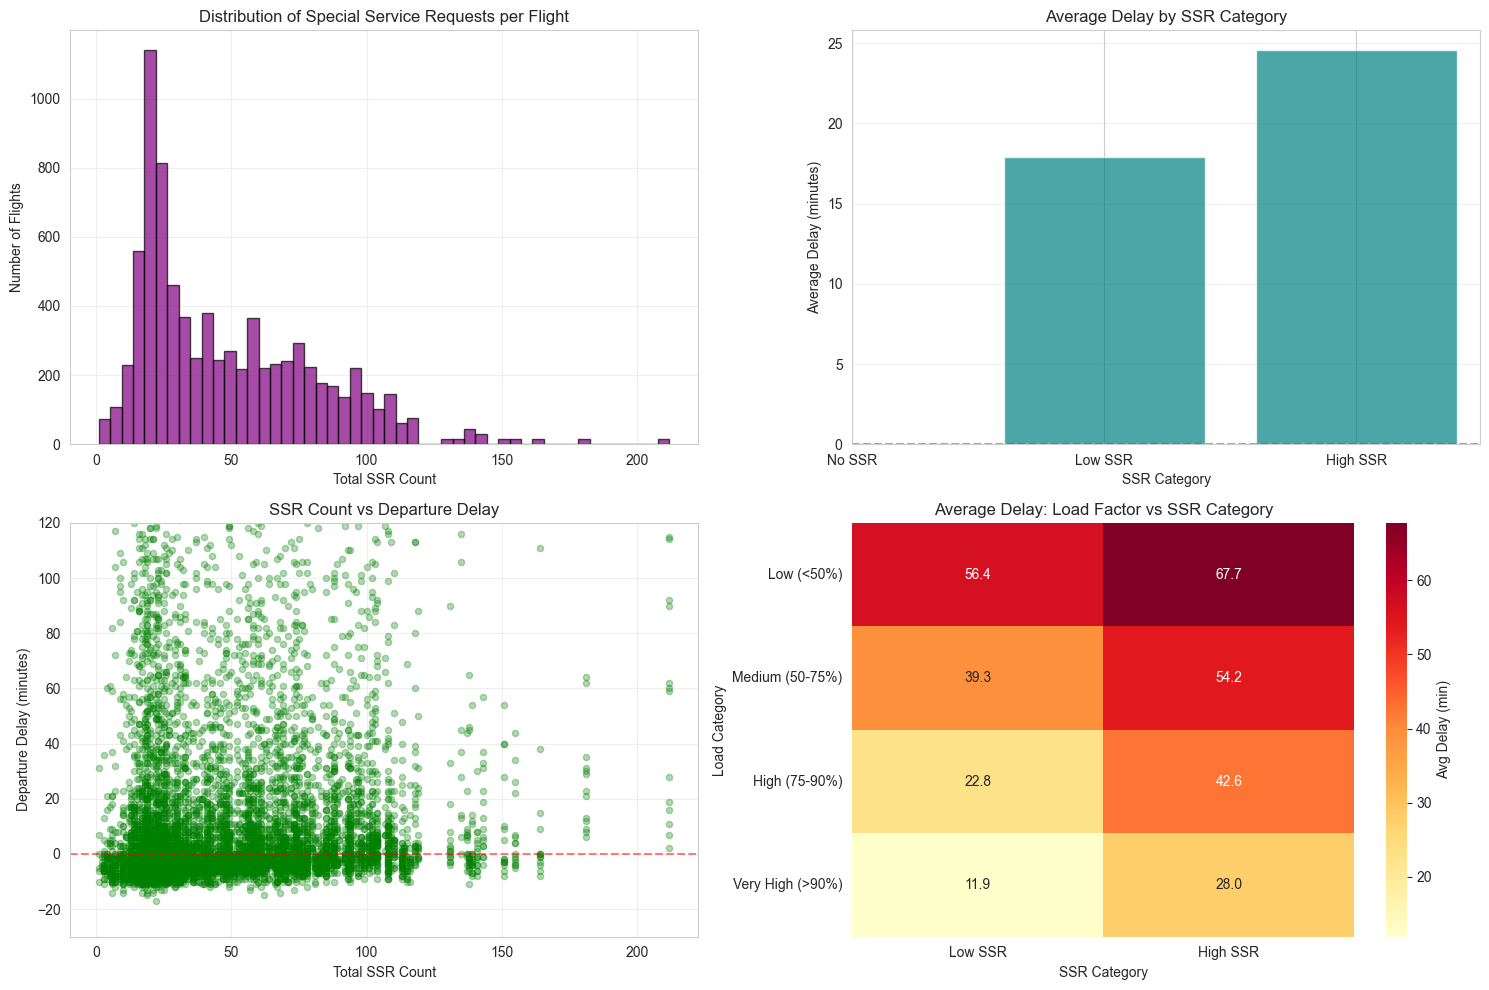

In [12]:
# Visualizations for SSR analysis
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# SSR distribution
axes[0, 0].hist(flight_with_ssr['total_ssr_count'], bins=50, edgecolor='black', alpha=0.7, color='purple')
axes[0, 0].set_xlabel('Total SSR Count')
axes[0, 0].set_ylabel('Number of Flights')
axes[0, 0].set_title('Distribution of Special Service Requests per Flight')
axes[0, 0].grid(True, alpha=0.3)

# Average delay by SSR category
avg_delay_by_ssr = flight_with_ssr.groupby('ssr_category')['departure_delay_minutes'].mean()
axes[0, 1].bar(range(len(avg_delay_by_ssr)), avg_delay_by_ssr.values, 
               tick_label=avg_delay_by_ssr.index, alpha=0.7, color='teal')
axes[0, 1].set_xlabel('SSR Category')
axes[0, 1].set_ylabel('Average Delay (minutes)')
axes[0, 1].set_title('Average Delay by SSR Category')
axes[0, 1].axhline(0, color='red', linestyle='--', alpha=0.5)
axes[0, 1].grid(True, alpha=0.3, axis='y')

# Scatter: SSR count vs Delay
valid_ssr_scatter = flight_with_ssr[['total_ssr_count', 'departure_delay_minutes']].dropna()
axes[1, 0].scatter(valid_ssr_scatter['total_ssr_count'], valid_ssr_scatter['departure_delay_minutes'], 
                   alpha=0.3, s=20, color='green')
axes[1, 0].set_xlabel('Total SSR Count')
axes[1, 0].set_ylabel('Departure Delay (minutes)')
axes[1, 0].set_title('SSR Count vs Departure Delay')
axes[1, 0].axhline(0, color='red', linestyle='--', alpha=0.5)
axes[1, 0].grid(True, alpha=0.3)
axes[1, 0].set_ylim(-30, 120)

# Heatmap: Load vs SSR impact on delay
load_ssr_pivot = flight_with_ssr.pivot_table(
    values='departure_delay_minutes',
    index='load_category',
    columns='ssr_category',
    aggfunc='mean'
)
sns.heatmap(load_ssr_pivot, annot=True, fmt='.1f', cmap='YlOrRd', ax=axes[1, 1], cbar_kws={'label': 'Avg Delay (min)'})
axes[1, 1].set_title('Average Delay: Load Factor vs SSR Category')
axes[1, 1].set_xlabel('SSR Category')
axes[1, 1].set_ylabel('Load Category')

plt.tight_layout()
fig.savefig(IMAGES_DIR / 'eda_special_service.png', dpi=200, bbox_inches='tight')
plt.show()

In [13]:
# Create a comprehensive summary dataframe
summary_results = {
    'Metric': [
        'Average Departure Delay (minutes)',
        'Percentage of Late Departures (%)',
        'Flights with Ground Time Risk',
        'Percentage with Ground Time Risk (%)',
        'Average Transfer to Checked Bag Ratio',
        'Average Load Factor (%)',
        'Correlation: Load Factor vs Delay',
        'Average SSRs per Flight',
        'Average Children per Flight',
        'Average Lap Children per Flight',
        'Average Basic Economy Passengers',
        'Average Stroller Users per Flight',
        'Average Hot Transfers per Flight'
    ],
    'Value': [
        f"{average_delay:.2f}",
        f"{pct_late_departures:.2f}",
        f"{risky_flights:,}",
        f"{pct_risky:.2f}",
        f"{avg_ratio:.4f}",
        f"{flight_with_pax['load_factor'].mean():.2f}",
        f"{correlation:.4f}",
        f"{flight_with_ssr['total_ssr_count'].mean():.2f}",
        f"{flight_with_pax['child_count'].mean():.2f}",
        f"{flight_with_pax['lap_child_count'].mean():.2f}",
        f"{flight_with_pax['basic_economy_pax'].mean():.2f}",
        f"{flight_with_pax['stroller_count'].mean():.2f}",
        f"{bag_pivot['Hot Transfer'].mean():.2f}" if 'Hot Transfer' in bag_pivot.columns else "0"
    ]
}

summary_df = pd.DataFrame(summary_results)
print("\n" + "="*60)
print("EDA SUMMARY")
print("="*60)
print(summary_df.to_string(index=False))

# Save to CSV
summary_df.to_csv(RESULTS_DIR / 'eda_summary_results.csv', index=False)
print("\nSummary saved to 'Result_CSVs/Deliverable-1/eda_summary_results.csv'")


EDA SUMMARY
                               Metric   Value
    Average Departure Delay (minutes)   21.18
    Percentage of Late Departures (%)   26.71
        Flights with Ground Time Risk     652
 Percentage with Ground Time Risk (%)    8.05
Average Transfer to Checked Bag Ratio  3.7179
              Average Load Factor (%)  102.42
    Correlation: Load Factor vs Delay -0.1502
              Average SSRs per Flight   48.75
          Average Children per Flight    5.18
      Average Lap Children per Flight    0.69
     Average Basic Economy Passengers   10.18
    Average Stroller Users per Flight    1.09
     Average Hot Transfers per Flight    4.56

Summary saved to 'Result_CSVs/Deliverable-1/eda_summary_results.csv'


In [14]:
flight_enriched = flight_with_ssr.copy()

# add bag data
bag_pivot_merge = bag_pivot.copy()
# Rename columns for readability
if 'Origin' in bag_pivot_merge.columns:
    bag_pivot_merge = bag_pivot_merge.rename(columns={'Origin': 'origin_bags'})
if 'Transfer' in bag_pivot_merge.columns:
    bag_pivot_merge = bag_pivot_merge.rename(columns={'Transfer': 'regular_transfer_bags'})
if 'Hot Transfer' in bag_pivot_merge.columns:
    bag_pivot_merge = bag_pivot_merge.rename(columns={'Hot Transfer': 'hot_transfer_bags'})

merge_cols = ['company_id', 'flight_number', 'scheduled_departure_date_local',
              'scheduled_departure_station_code', 'scheduled_arrival_station_code']

bag_cols_to_merge = merge_cols + [col for col in ['origin_bags', 'regular_transfer_bags', 'hot_transfer_bags', 
                                                     'Checked', 'All_Transfers', 'total_bags', 
                                                     'transfer_to_checked_ratio', 'hot_transfer_pct']
                                   if col in bag_pivot_merge.columns]

flight_enriched = flight_enriched.merge(
    bag_pivot_merge[bag_cols_to_merge],
    on=merge_cols,
    how='left'
)

print(f"Enriched dataset shape: {flight_enriched.shape}")
print(f"\nColumns in enriched dataset:")
print(flight_enriched.columns.tolist())

# Show sample of the enriched data
print("\nSample of enriched data:")
print(flight_enriched.head())

# key statistics
print("\n" + "="*60)
print("ENRICHED DATASET STATISTICS")
print("="*60)
print(f"Total flights: {len(flight_enriched):,}")
print(f"Date range: {flight_enriched['scheduled_departure_date_local'].min()} to {flight_enriched['scheduled_departure_date_local'].max()}")
print(f"Unique destinations: {flight_enriched['scheduled_arrival_station_code'].nunique()}")
print(f"Carriers: {flight_enriched['carrier'].unique()}")
print(f"Fleet types: {flight_enriched['fleet_type'].nunique()}")

flight_enriched.to_csv(RESULTS_DIR / 'flight_enriched_eda.csv', index=False)
print("\nEnriched dataset saved to 'Result_CSVs/Deliverable-1/flight_enriched_eda.csv'")
print("\nThis file can be used for developing the Flight Difficulty Score!")

# summary of key operational metrics
print("\n" + "="*60)
print("KEY OPERATIONAL METRICS SUMMARY")
print("="*60)
operational_summary = flight_enriched[[
    'departure_delay_minutes', 'load_factor', 'total_bags', 
    'total_ssr_count', 'ground_time_buffer', 'child_count'
]].describe().round(2)
print(operational_summary)

Enriched dataset shape: (8099, 39)

Columns in enriched dataset:
['company_id', 'flight_number', 'scheduled_departure_date_local', 'scheduled_departure_station_code', 'scheduled_arrival_station_code', 'scheduled_departure_datetime_local', 'scheduled_arrival_datetime_local', 'actual_departure_datetime_local', 'actual_arrival_datetime_local', 'total_seats', 'fleet_type', 'carrier', 'scheduled_ground_time_minutes', 'actual_ground_time_minutes', 'minimum_turn_minutes', 'departure_delay_minutes', 'ground_time_risk', 'ground_time_buffer', 'total_pax', 'lap_child_count', 'child_count', 'basic_economy_pax', 'stroller_count', 'load_factor', 'load_category', 'child_ratio', 'basic_econ_ratio', 'total_ssr_count', 'unique_pnr_with_ssr', 'ssr_per_pax', 'ssr_category', 'origin_bags', 'regular_transfer_bags', 'hot_transfer_bags', 'Checked', 'All_Transfers', 'total_bags', 'transfer_to_checked_ratio', 'hot_transfer_pct']

Sample of enriched data:
  company_id  flight_number scheduled_departure_date_loca

In [15]:
# data quality check
print("="*60)
print("DATA QUALITY CHECK")
print("="*60)

print("\nMissing Values in Key Columns:")
missing_check = flight_enriched[[
    'departure_delay_minutes', 'load_factor', 'total_pax', 
    'total_bags', 'total_ssr_count', 'ground_time_buffer'
]].isnull().sum()
print(missing_check)

print("\nFlights with complete data for all key metrics:")
complete_cases = flight_enriched[[
    'departure_delay_minutes', 'load_factor', 'total_pax', 
    'total_bags', 'total_ssr_count', 'ground_time_buffer'
]].notna().all(axis=1).sum()
print(f"{complete_cases:,} flights ({complete_cases/len(flight_enriched)*100:.2f}%)")

print("\nFlights by Carrier:")
print(flight_enriched['carrier'].value_counts())

print("\nTop 10 Destinations by Flight Count:")
print(flight_enriched['scheduled_arrival_station_code'].value_counts().head(10))

DATA QUALITY CHECK

Missing Values in Key Columns:
departure_delay_minutes    0
load_factor                0
total_pax                  0
total_bags                 4
total_ssr_count            0
ground_time_buffer         0
dtype: int64

Flights with complete data for all key metrics:
8,095 flights (99.95%)

Flights by Carrier:
carrier
Mainline    4502
Express     3597
Name: count, dtype: int64

Top 10 Destinations by Flight Count:
scheduled_arrival_station_code
LGA    188
IAH    160
LAX    155
SFO    155
DCA    153
EWR    148
DEN    148
BOS    121
STL    117
IND    104
Name: count, dtype: int64
